In [68]:
# Load libraries 
import os
import faiss
import numpy as np
import pandas as pd 
from time import time
import seaborn as sns
from typing import Union
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

In [69]:
# Set visualisation style
plt.style.use("ggplot")

In [70]:
# Load pretrained model 
model = SentenceTransformer("msmarco-MiniLM-L-6-v3")

In [71]:
# Define required columns
required_column = ['Nama Produk / Rincian', 'Kode KBLI', 'Jenis Produk']

In [122]:
# Load training dataset - v2
data_train = pd.read_excel("../dataset/v2/kbli_prediksi_jenis_training_set.xlsx", usecols = required_column)
data_test = pd.read_excel("../dataset/v2/kbli_prediksi_jenis_testing_set.xlsx", usecols = required_column)

In [123]:
# Clean KBLI and Jenis Produk
data_train[data_train['Kode KBLI'].apply(lambda x: len(str(x).split(",")) > 1 or len(str(x).strip()) == 0)]

,Nama Produk / Rincian,Kode KBLI,Jenis Produk
346,"Ikan dan produk perikanan yang diawetkan, term...","10215, 10295, 10221,10222",Industri Pengolahan dan Pengawetan Ikan dan Bi...
356,Amonium fosfatidat (ammonium phosphatide),"20118,20119",Industri Kimia Dasar Organik Yang Menghasilkan...
497,Trinatrium sitrat (trisodium citrate),"20119, 20118",- 20119 (Industri Kimia Dasar Organik Lainnya)...
688,Ikan dan produk perikanan termasuk m...,"10219, 10299, 2125, 2126",Industri Pemindangan Ikan
756,Rumput laut eucheuma olahan (processed eu...,"03114, 03211, 03212, 10799",- 03114 (Penangkapan/Pengambilan Tumbuhan Air ...
763,Dulce de leche/susu caramel manis,,Industri Pengolahan Produk dari Susu Lainnya
786,Produk buah untuk isi pastri,"10733,10313",Industri Manisan Buah-buahan Dan Sayuran Kering


In [124]:
data_train[data_train['Kode KBLI'].apply(lambda x: len(str(x).split(",")) > 1 or len(str(x).strip()) == 0)].to_dict("records")

[{'Nama Produk / Rincian': 'Ikan dan produk perikanan yang diawetkan, termasuk ikan  dan  produk  perikanan  yang  dikalengkan  atau difermentasi,    termasuk    moluska,    krustase    dan ekinodermata',
  'Kode KBLI': '10215, 10295, 10221,10222',
  'Jenis Produk': 'Industri Pengolahan dan Pengawetan Ikan dan Biota Air (Bukan Udang) Dalam Kaleng'},
 {'Nama Produk / Rincian': 'Amonium fosfatidat (ammonium phosphatide)',
  'Kode KBLI': '20118,20119',
  'Jenis Produk': 'Industri Kimia Dasar Organik Yang Menghasilkan Bahan Kimia Khusus (termasuk bahan tambahan makanan),Industri Kimia Dasar Organik Lainnya'},
 {'Nama Produk / Rincian': 'Trinatrium sitrat (trisodium citrate)',
  'Kode KBLI': '20119, 20118',
  'Jenis Produk': '- 20119 (Industri Kimia Dasar Organik Lainnya)\n- 20118 (Industri Kimia Dasar Organik Yang Menghasilkan Bahan Kimia Khusus (termasuk bahan tambahan makanan))\nLebih cocok ke 20118'},
 {'Nama Produk / Rincian': 'Ikan   dan   produk   perikanan   termasuk   moluska, krus

In [125]:
# Manual Replacement
data_train.iloc[346]['Kode KBLI'] = 10221

data_train.iloc[497]['Kode KBLI'] = 20118
data_train.iloc[497]['Jenis Produk'] = "Industri Kimia Dasar Organik Yang Menghasilkan Bahan Kimia Khusus (termasuk bahan tambahan makanan)"

data_train.iloc[688]['Kode KBLI'] = 10214

data_train.iloc[756]['Kode KBLI'] = 10799 
data_train.iloc[756]['Jenis Produk'] = "Industri Produk Makanan Lainnya"

data_train.iloc[356]['Kode KBLI'] = 20118

data_train.iloc[786]['Kode KBLI'] = 10733

data_train.iloc[763]['Kode KBLI'] = 10590

In [126]:
# Validate Kode KBLI
data_train[data_train['Kode KBLI'].apply(lambda x: len(str(x).split(",")) > 1)]

,Nama Produk / Rincian,Kode KBLI,Jenis Produk


In [127]:
# Convert Kode KBLI into "int"
data_train['Kode KBLI'] = data_train['Kode KBLI'].astype(int)

In [128]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1046 entries, 0 to 1045
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Nama Produk / Rincian  1046 non-null   object
 1   Kode KBLI              1046 non-null   int32 
 2   Jenis Produk           1046 non-null   object
dtypes: int32(1), object(2)
memory usage: 20.6+ KB


In [129]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262 entries, 0 to 261
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Nama Produk / Rincian  262 non-null    object
 1   Kode KBLI              262 non-null    int64 
 2   Jenis Produk           262 non-null    object
dtypes: int64(1), object(2)
memory usage: 6.3+ KB


In [148]:
# Concat dataset and remove duplicate
data_train = pd.concat([data_train, data_test]).drop_duplicates().reset_index()

In [149]:
# Create training dataset into hashmaps
data_train_maps = data_train.to_dict("records")

In [150]:
# Overview dataset
data_train.head()

,index,Nama Produk / Rincian,Kode KBLI,Jenis Produk
0,0,Keju edam,10590,Industri Pengolahan Produk dari Susu Lainnya
1,1,Kaldu dan konsome,10799,Industri Produk Makanan Lainnya
2,2,Paprika bubuk,10772,Industri Bumbu Masak Dan Penyedap Masakan
3,3,Sukrosa asetat isobutirat (sucrose acetate iso...,10623,Industri Glukosa Dan Sejenisnya
4,4,Tepung bakso,10614,Industri Tepung Campuran dan Adonan Tepung


In [151]:
# Check dimension
data_train.shape

(1308, 4)

In [152]:
# Overview missing values
data_train.isna().sum()

index                    0
Nama Produk / Rincian    0
Kode KBLI                0
Jenis Produk             0
dtype: int64

In [153]:
# Overview Sentence Length
sentence_length = data_train['Nama Produk / Rincian'].apply(
    lambda sentence: len(sentence.split())
).tolist()
max_sentence_length = np.round(np.mean(sentence_length) + np.std(sentence_length)).astype("int")

C:\Users\alif\anaconda3\envs\test\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


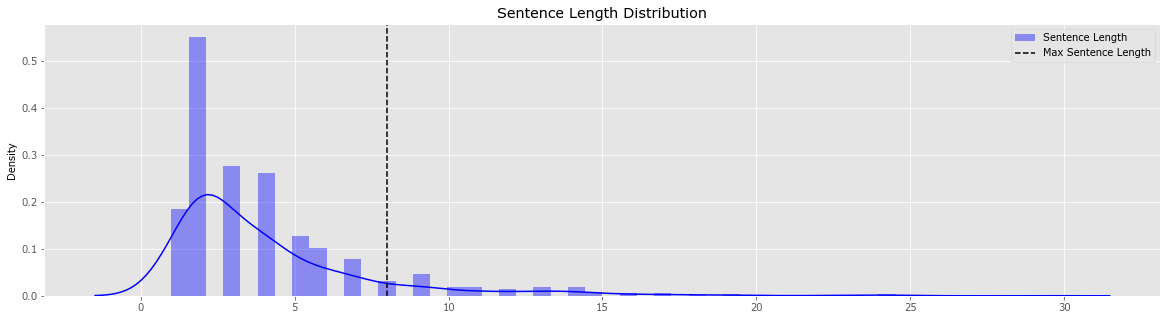

In [154]:
# Visualize density of sentence length distribution
plt.figure(figsize = (20, 5))
sns.distplot(sentence_length, hist = True, kde = True, color = "blue", label = "Sentence Length")
plt.axvline(x = max_sentence_length, color = "k", linestyle = "--", label = "Max Sentence Length")
plt.title("Sentence Length Distribution")
plt.legend()
plt.show()

In [155]:
# Convert Embedding
encoded_sentence = model.encode(data_train['Nama Produk / Rincian'].tolist(), show_progress_bar = True)
encoded_sentence = np.asarray(encoded_sentence.astype("float16"))

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

In [156]:
# Check dimension
encoded_sentence.shape

(1308, 384)

In [157]:
# Create & Insert Index Faiss
index = faiss.IndexIDMap(faiss.IndexFlatIP(384))
index.add_with_ids(encoded_sentence, np.array(range(0, len(data_train))))
faiss.write_index(index, "corpus/reguler.index")

In [158]:
# Create function to indexing results
def fetch_product(idx: int, query: str, df: pd.DataFrame = data_train_maps):
    result = {}
    result["query"] = query
    try:
        info = df[idx]
        result["nama_produk_terdekat"]    = info['Nama Produk / Rincian']
        result["prediksi_jenis"] = info["Jenis Produk"]
        result["prediksi_kbli"]  = info["Kode KBLI"]
        result["message"]        = "Prediction Success"
    except IndexError:
        result["nama_produk_terdekat"]    = ""
        result["prediksi_jenis"] = ""
        result["prediksi_kbli"]  = ""
        result["message"]        = "Prediction Failed "
    return result

def search(query: str, index_vector: object = index, model_embedding: object = model, mode: Union["Pred", "Eval"] = "Pred", column_test: str = None):
    query_vector = model_embedding.encode([query])
    selected_idx = index_vector.search(query_vector, k = 1)
    selected_idx = selected_idx[1].tolist()[0][0]
    if mode == "Pred":
        result = [fetch_product(selected_idx, query)]
    if mode == "Eval":
        if column_test is None:
            raise Exception(f"'column_test' should have parameter is using 'Eval' value in parameter 'mode'")
        result = data_train[column_test][selected_idx]
    return result

In [159]:
%%time
# Test result
nama_produk_test = "Kacang"
result_prediction = search(nama_produk_test)

print(result_prediction)

[{'query': 'Kacang', 'nama_produk_terdekat': 'Kacang goyang', 'prediksi_jenis': 'Industri Pengolahan dan Pengawetan Kedelai dan Kacang-kacangan Lainnya Selain Tahu dan Tempe', 'prediksi_kbli': 10393, 'message': 'Prediction Success'}]
CPU times: total: 0 ns
Wall time: 16.7 ms


In [160]:
# Load libraries 
from tqdm import tqdm
from sklearn.metrics import accuracy_score

In [161]:
# Load testing dataset - v2
data_test = pd.read_excel("../dataset/v2/kbli_prediksi_jenis_testing_set.xlsx")

In [162]:
# Check dimension
data_test.shape

(262, 3)

In [163]:
# Overview dataset
data_test.head()

,Nama Produk / Rincian,Kode KBLI,Jenis Produk
0,Chutney mangga (mango chutney),10399,Industri Pengolahan dan Pengawetan Lainnya Bua...
1,Minyak masak atau minyak sayur (cooking oil),10411,Industri Minyak Mentah dan Lemak Nabati
2,Asinan jahe,10311,Industri Pengasinan Buah-buahan Dan Sayuran
3,Selongsong sosis kolagen,10799,Industri Produk Makanan Lainnya
4,Buah dalam kemasan,10399,Industri Pengolahan dan Pengawetan Lainnya Bua...


In [164]:
# Apply prediction
predictions_jenis_produk = list(map(lambda x: search(x, mode = "Eval", column_test = "Jenis Produk"), tqdm(data_test['Nama Produk / Rincian'], desc = "Predictions")))
predictions_kbli_produk  = list(map(lambda x: search(x, mode = "Eval", column_test = "Kode KBLI"), tqdm(data_test['Nama Produk / Rincian'], desc = "Predictions")))

Predictions: 100%|███████████████████████████████████████████████████████████████████| 262/262 [00:03<00:00, 70.74it/s]


In [165]:
# Evaluate Score
print(f"Acc. Jenis Produk: {accuracy_score(data_test['Jenis Produk'].tolist(), predictions_jenis_produk)}")
print(f"Acc. Kode  KBLI  : {accuracy_score(data_test['Kode KBLI'].tolist(), predictions_kbli_produk)}")

Acc. Jenis Produk: 0.9847328244274809
Acc. Kode  KBLI  : 0.9847328244274809


In [166]:
# Save data_train as json
import json
json.dump(data_train_maps, open("corpus/reguler.json", "w"), indent = 4)